# Data Preparation - Viral Social Media Trends Analysis

In [88]:
# Imports
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports loaded")

Imports loaded


## Configurations

In [89]:
# Paths
RAW_DATA_PATH = "data/raw/Viral_Social_Media_Trends.csv"
PROCESSED_DIR = Path("data/processed")
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = Path("artifacts/figures")

# Create directories
for dir_path in [PROCESSED_DIR, ARTIFACTS_DIR, FIGURES_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)
    # Clear all files in directory
    for file in dir_path.glob('*'):
        if file.is_file():
            file.unlink()

# Constants
# TODO : Implement needed constraints

print("✅ Configuration loaded")


IQR_MULTIPLIER = 1.5

✅ Configuration loaded


## Helper Functions

In [90]:
def calculate_iqr_bounds(series, multiplier=1.5):
    """Calculate IQR-based outlier bounds"""
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - multiplier * iqr, q3 + multiplier * iqr

# TODO : Implement other Functions here 

def build_preprocessor(nominal_cols, ordinal_cols, ordinal_categories, numeric_cols):
    """Build preprocessing pipeline - Steps 6 & 7"""
    transformers = [
        ('num', Pipeline([
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('nom', Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01, sparse_output=False))
        ]), nominal_cols)
    ]
    
    if ordinal_cols:
        transformers.append(('ord', Pipeline([
            ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1))
        ]), ordinal_cols))
    
    return ColumnTransformer(transformers)

def extract_feature_names(fitted_ct):
    """Extract feature names from fitted ColumnTransformer"""
    names = []
    for name, transformer, columns in fitted_ct.transformers_:
        if name == 'num':
            names.extend(columns)
        elif name == 'nom':
            names.extend(transformer.named_steps['onehot'].get_feature_names_out(columns))
        elif name == 'ord':
            names.extend(columns)
    return names


def categorize_rate(er):
    if er < 1:
        return "Low"
    elif er < 5:
        return "Medium"
    else:
        return "High"

print("✅ Helper functions defined")





✅ Helper functions defined


## Load Raw Data

In [91]:
df_raw = pd.read_csv(RAW_DATA_PATH)
print(f"✅ Loaded {len(df_raw):,} rows, {len(df_raw.columns)} columns")

# Drop unnecessary text columns immediately
df_raw = df_raw.drop(columns=['Post_ID'], errors='ignore')
print(f"✅ Dropped POST_ID column")

print(f"\nColumns: {list(df_raw.columns)}")
df_raw.head(3)


✅ Loaded 5,000 rows, 10 columns
✅ Dropped POST_ID column

Columns: ['Platform', 'Hashtag', 'Content_Type', 'Region', 'Views', 'Likes', 'Shares', 'Comments', 'Engagement_Level']


,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level
0,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High
1,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium
2,Twitter,#Challenge,Video,Brazil,3666211,327143,39423,36223,Medium


MISSING VALUE ANALYSIS
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Pct]
Index: []


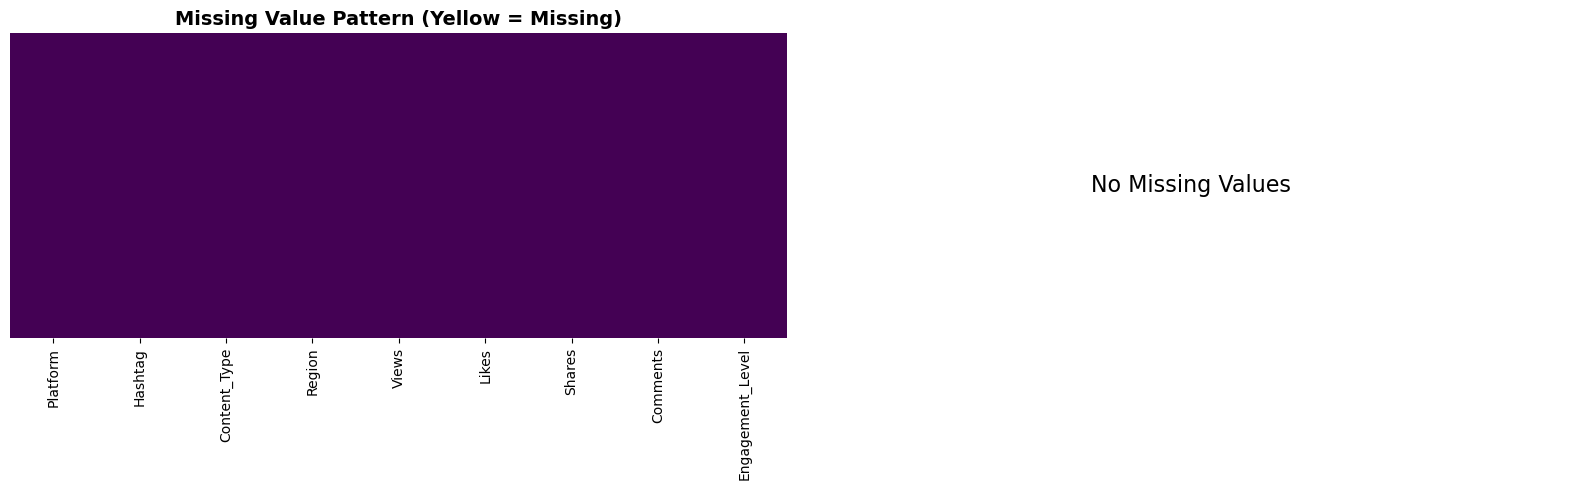


✅ Missing value analysis saved to artifacts\figures\missing_values_analysis.png

📝 Strategy: Impute after split (Step 3) using TRAIN statistics only


In [92]:
# Missing value statistics
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Pct': missing_pct.values
}).sort_values('Missing_Count', ascending=False)

print("=" * 80)
print("MISSING VALUE ANALYSIS")
print("=" * 80)
print(missing_df[missing_df['Missing_Count'] > 0].to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Heatmap
sns.heatmap(df_raw.isnull(), cbar=False, yticklabels=False, cmap='viridis', ax=ax1)
ax1.set_title('Missing Value Pattern (Yellow = Missing)', fontsize=14, fontweight='bold')

# Bar chart
missing_nonzero = missing_df[missing_df['Missing_Count'] > 0]
if len(missing_nonzero) > 0:
    ax2.barh(missing_nonzero['Column'], missing_nonzero['Missing_Pct'], color='coral', edgecolor='black')
    ax2.set_xlabel('Missing %', fontsize=12)
    ax2.set_title('Missing Value Percentage by Column', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    for i, (col, pct) in enumerate(zip(missing_nonzero['Column'], missing_nonzero['Missing_Pct'])):
        ax2.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=10)
else:
    ax2.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=16, transform=ax2.transAxes)
    ax2.axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'missing_values_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Missing value analysis saved to {FIGURES_DIR / 'missing_values_analysis.png'}")
print(f"\n📝 Strategy: Impute after split (Step 3) using TRAIN statistics only")


## Exploratory Data Analysis

In [93]:
print("Data Summary:")
print(df_raw.describe())
print(f"\n✅ EDA complete - Ready for STEP 2: Split")

Data Summary:
              Views          Likes        Shares      Comments
count  5.000000e+03    5000.000000   5000.000000   5000.000000
mean   2.494066e+06  251475.029800  50519.562000  24888.393800
std    1.459490e+06  144349.583384  29066.362671  14284.504319
min    1.266000e+03     490.000000     52.000000     18.000000
25%    1.186207e+06  126892.250000  25029.000000  12305.250000
50%    2.497373e+06  249443.000000  50839.500000  25004.000000
75%    3.759781e+06  373970.750000  75774.250000  37072.750000
max    4.999430e+06  499922.000000  99978.000000  49993.000000

✅ EDA complete - Ready for STEP 2: Split


In [94]:
df_raw.describe()

,Views,Likes,Shares,Comments
count,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,2.494066e+06,251475.029800,50519.562000,24888.393800
std,1.459490e+06,144349.583384,29066.362671,14284.504319
min,1.266000e+03,490.000000,52.000000,18.000000
25%,1.186207e+06,126892.250000,25029.000000,12305.250000
50%,2.497373e+06,249443.000000,50839.500000,25004.000000
75%,3.759781e+06,373970.750000,75774.250000,37072.750000
max,4.999430e+06,499922.000000,99978.000000,49993.000000


In [95]:
df_raw.describe(include='object')
for col in df_raw.select_dtypes(include='object').columns:
    print(f"\n{col}: {df_raw[col].nunique()} unique values")
    print(df_raw[col].unique())


Platform: 4 unique values
['TikTok' 'Instagram' 'Twitter' 'YouTube']

Hashtag: 10 unique values
['#Challenge' '#Education' '#Dance' '#Comedy' '#Gaming' '#Music' '#Viral'
 '#Fitness' '#Tech' '#Fashion']

Content_Type: 6 unique values
['Video' 'Shorts' 'Post' 'Tweet' 'Live Stream' 'Reel']

Region: 8 unique values
['UK' 'India' 'Brazil' 'Australia' 'Japan' 'Germany' 'Canada' 'USA']

Engagement_Level: 3 unique values
['High' 'Medium' 'Low']


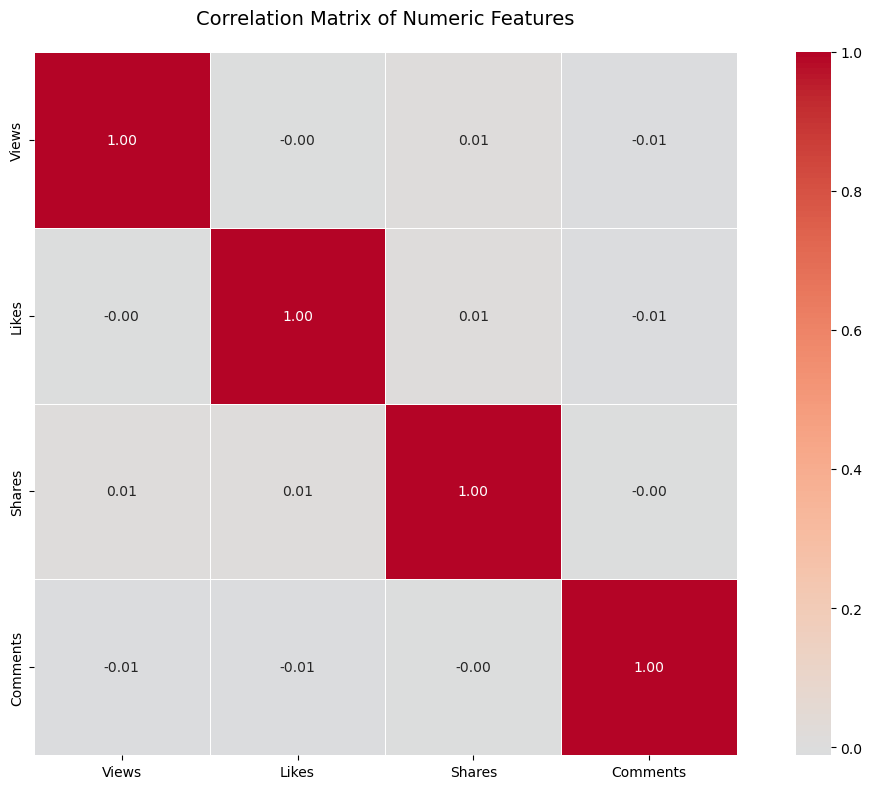


✅ Correlation analysis saved to artifacts\figures\correlation_matrix.png


In [96]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
numeric_cols = df_raw.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_raw[numeric_cols].corr()

# Create heatmap
sns.heatmap(
            correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True,
            linewidths=0.5
            )

plt.title('Correlation Matrix of Numeric Features', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Correlation analysis saved to {FIGURES_DIR / 'correlation_matrix.png'}")


## Data Visualization

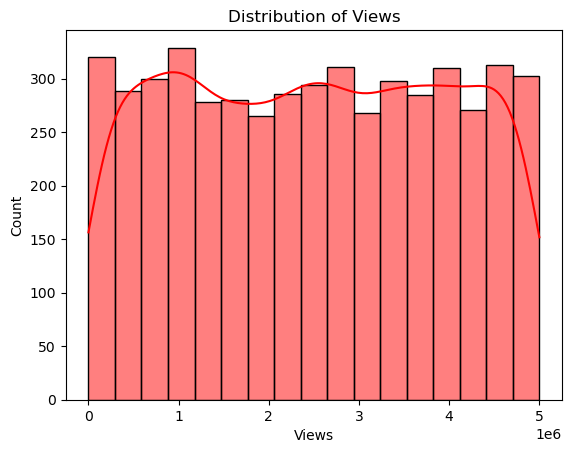

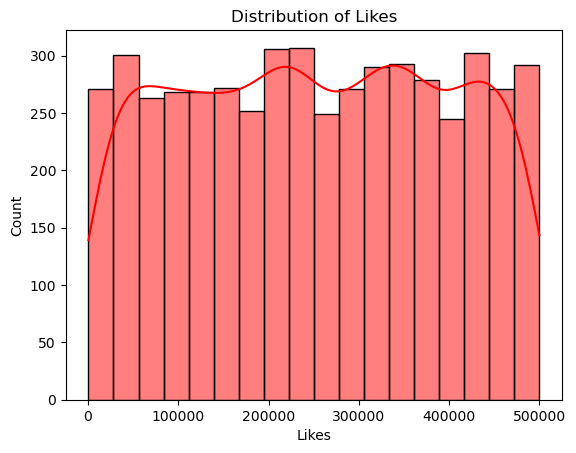

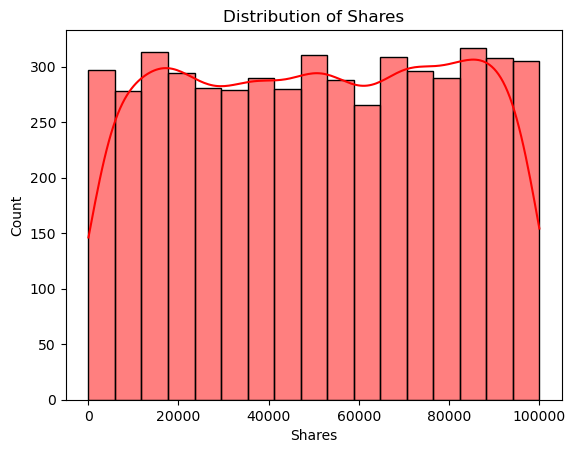

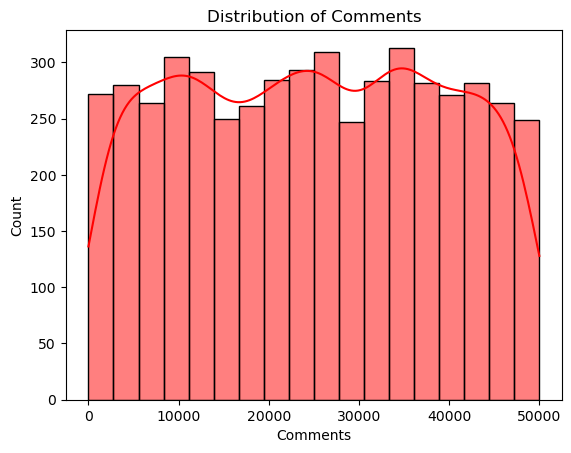

In [97]:
# Histograms for distribution
for i in df_raw.select_dtypes(include="number").columns:
    sns.histplot(data=df_raw, x=i, kde=True, color="red")
    plt.title(f'Distribution of {i}')
    plt.savefig(FIGURES_DIR / f'Histogram-distribution of {i}.png', dpi=150, bbox_inches='tight')
    plt.tight_layout
    plt.show()

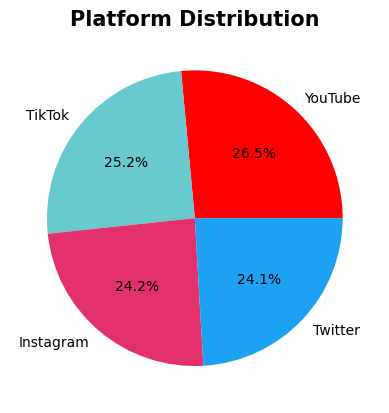

In [98]:
count = df_raw['Platform'].value_counts()
colors = ["#FF0000", "#69C9D0", "#E1306C", "#1DA1F2"]
plt.pie(count, labels=count.index, colors=colors ,autopct='%1.1f%%')
plt.title('Platform Distribution', fontsize=15 , weight='bold')
plt.savefig(FIGURES_DIR / f'PieChart.png', dpi=150, bbox_inches='tight')
plt.show()

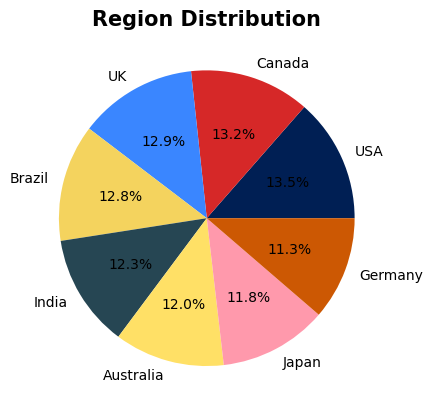

In [99]:
region_distribution = df_raw['Region'].value_counts()
colors = [ "#001f54" ,"#d62828","#3a86ff","#f4d35e","#264653","#ffe066","#ff99ac","#cc5803","#001f54" ,"#d62828" ]
plt.pie(region_distribution, labels=region_distribution.index, autopct='%1.1f%%', colors=colors)
plt.title('Region Distribution', fontsize=15 , weight='bold')
plt.savefig(FIGURES_DIR / f'Region Piechart.png', dpi=150, bbox_inches='tight')
plt.show()

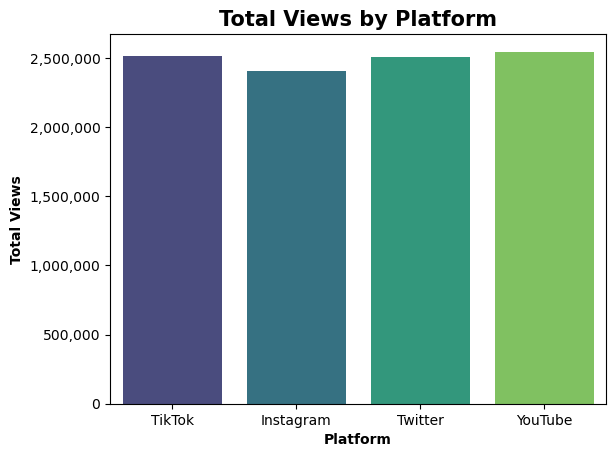

In [100]:
from matplotlib.ticker import FuncFormatter
sns.barplot(x='Platform', y='Views',data=df_raw, palette='viridis',ci=False)
plt.title('Total Views by Platform', fontsize=15 , weight='bold')
plt.xlabel('Platform', weight='bold')
plt.ylabel('Total Views', weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.savefig(FIGURES_DIR / f'Barchart-Platform.png', dpi=150, bbox_inches='tight')
plt.show()

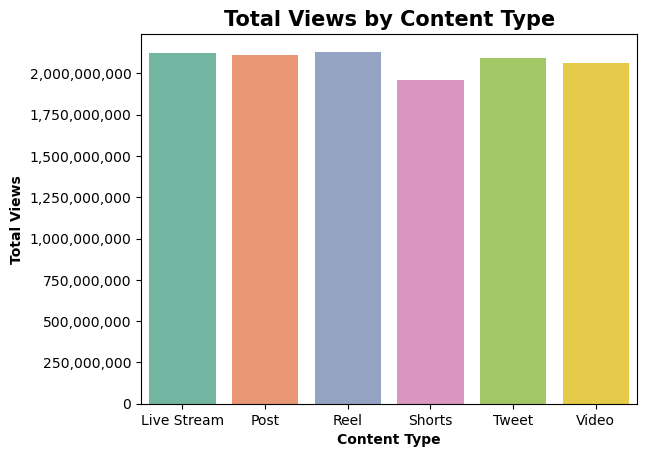

In [101]:
content_views = df_raw.groupby('Content_Type')['Views'].sum().reset_index()
sns.barplot(x='Content_Type', y='Views', data=content_views, palette='Set2')
plt.title('Total Views by Content Type', fontsize=15 , weight='bold')
plt.xlabel('Content Type', weight='bold')
plt.ylabel('Total Views', weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.savefig(FIGURES_DIR / f'Barchart-ContentType.png', dpi=150, bbox_inches='tight')
plt.show()

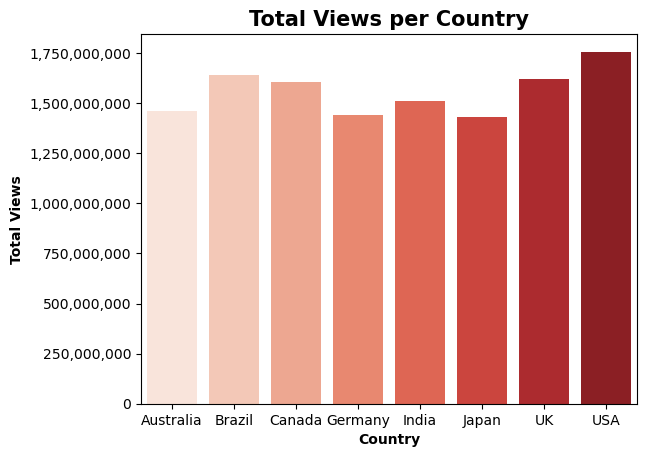

In [102]:
views_per_country = df_raw.groupby('Region')['Views'].sum()
sns.barplot(x=views_per_country.index, y=views_per_country.values , palette='Reds')
plt.title('Total Views per Country', fontsize=15 , weight='bold')
plt.xlabel('Country', weight='bold')
plt.ylabel('Total Views', weight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.savefig(FIGURES_DIR / f'Barchart-Country.png', dpi=150, bbox_inches='tight')
plt.show()

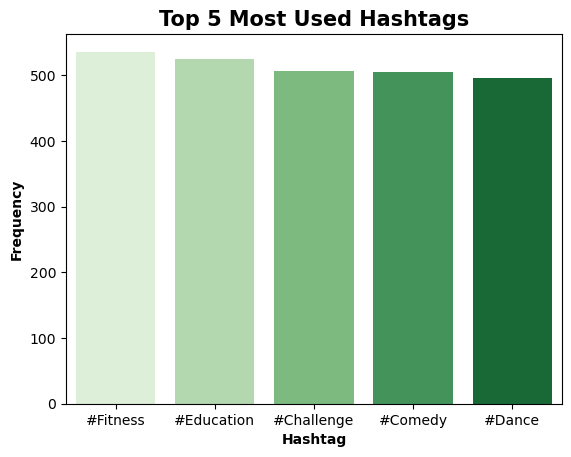

In [103]:
most5_used_hastags = df_raw['Hashtag'].value_counts().sort_values(ascending=False).nlargest(5)
sns.barplot(x=most5_used_hastags.index, y=most5_used_hastags.values, palette='Greens')
plt.title('Top 5 Most Used Hashtags', fontsize=15 , weight='bold')
plt.xlabel('Hashtag', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.savefig(FIGURES_DIR / f'Barchart-Hashtags.png', dpi=150, bbox_inches='tight')
plt.show()

In [104]:
# Identify rows where engagement seems inconsistent

#Likes are greater than views
df_raw[df_raw['Likes'] > df_raw['Views']]





,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level
4,TikTok,#Dance,Post,Brazil,64866,171361,69581,6376,Medium
20,Twitter,#Gaming,Video,Brazil,14095,268310,90495,16968,Low
36,Instagram,#Music,Reel,Germany,48908,205884,37256,14618,Low
45,Instagram,#Gaming,Tweet,Brazil,272327,274271,56073,17526,High
81,Instagram,#Dance,Live Stream,Australia,284772,338933,22771,18899,Low
...,...,...,...,...,...,...,...,...,...
4944,TikTok,#Comedy,Video,Australia,31732,140297,38920,3503,Medium
4957,Instagram,#Fitness,Live Stream,Australia,38930,295330,60125,42066,High
4970,Twitter,#Fitness,Live Stream,USA,263389,330087,71596,11742,Low
4985,TikTok,#Music,Live Stream,India,379978,409651,84380,34427,Low


In [105]:
#Shares are greater than views
df_raw[df_raw['Shares'] > df_raw['Views']]

,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level
4,TikTok,#Dance,Post,Brazil,64866,171361,69581,6376,Medium
20,Twitter,#Gaming,Video,Brazil,14095,268310,90495,16968,Low
104,Instagram,#Fitness,Post,Japan,13562,11483,33641,30457,Medium
430,Twitter,#Gaming,Video,India,40081,388209,72017,26138,Medium
621,YouTube,#Fitness,Live Stream,USA,93786,193921,95093,14218,Medium
800,Instagram,#Dance,Reel,Canada,34258,99120,37011,3149,High
918,Twitter,#Viral,Tweet,Canada,6651,22479,24947,11283,Medium
1033,Instagram,#Education,Tweet,Australia,11338,379782,86100,44273,Medium
1097,YouTube,#Fashion,Tweet,UK,97528,402649,98985,48533,Medium
1399,Instagram,#Comedy,Live Stream,Australia,23823,40878,92816,32364,Medium


In [106]:

#Comments greater than views
df_raw[df_raw['Comments'] > df_raw['Views']]



,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level
20,Twitter,#Gaming,Video,Brazil,14095,268310,90495,16968,Low
104,Instagram,#Fitness,Post,Japan,13562,11483,33641,30457,Medium
415,Twitter,#Music,Tweet,India,17826,347482,13497,25800,Medium
529,Twitter,#Tech,Reel,USA,18921,150828,7751,27357,Medium
918,Twitter,#Viral,Tweet,Canada,6651,22479,24947,11283,Medium
1033,Instagram,#Education,Tweet,Australia,11338,379782,86100,44273,Medium
1399,Instagram,#Comedy,Live Stream,Australia,23823,40878,92816,32364,Medium
1513,Instagram,#Gaming,Post,Canada,18259,325660,50504,27761,Low
1537,YouTube,#Challenge,Video,Canada,20509,237516,66323,41897,Medium
1540,Instagram,#Comedy,Live Stream,Japan,4323,301571,81786,30318,Low


In [107]:
# Identify rows where all greater than views
df_raw[(df_raw['Likes'] > df_raw['Views']) &
       (df_raw['Shares'] > df_raw['Views']) &
       (df_raw['Comments'] > df_raw['Views'])] 

,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level
20,Twitter,#Gaming,Video,Brazil,14095,268310,90495,16968,Low
918,Twitter,#Viral,Tweet,Canada,6651,22479,24947,11283,Medium
1033,Instagram,#Education,Tweet,Australia,11338,379782,86100,44273,Medium
1399,Instagram,#Comedy,Live Stream,Australia,23823,40878,92816,32364,Medium
1513,Instagram,#Gaming,Post,Canada,18259,325660,50504,27761,Low
1537,YouTube,#Challenge,Video,Canada,20509,237516,66323,41897,Medium
1540,Instagram,#Comedy,Live Stream,Japan,4323,301571,81786,30318,Low
1834,YouTube,#Dance,Tweet,Australia,21300,339452,57791,30571,High
2647,YouTube,#Challenge,Post,USA,8982,353646,77267,39542,Medium
2957,TikTok,#Fitness,Tweet,Japan,22280,294546,89803,22578,Medium


In [108]:
df_raw.describe()

,Views,Likes,Shares,Comments
count,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,2.494066e+06,251475.029800,50519.562000,24888.393800
std,1.459490e+06,144349.583384,29066.362671,14284.504319
min,1.266000e+03,490.000000,52.000000,18.000000
25%,1.186207e+06,126892.250000,25029.000000,12305.250000
50%,2.497373e+06,249443.000000,50839.500000,25004.000000
75%,3.759781e+06,373970.750000,75774.250000,37072.750000
max,4.999430e+06,499922.000000,99978.000000,49993.000000


#### Define feature columns

### Feature Engineering

In [109]:
"""
Feature Engineering to resolve conflicts between views and other metrics,
done before splitting because they do not use statistics"""

print("STEP 2: Feature Engineering (Safe - Before Split)")
print("="*60)

# Basic interaction totals
df_raw['total_interactions'] = df_raw['Likes'] + df_raw['Shares'] + df_raw['Comments']

# Engagement rates (ratio-based)
df_raw['engagement_rate'] = df_raw['Likes'] / (df_raw['Views'] + 1)
df_raw['share_rate'] = df_raw['Shares'] / (df_raw['Views'] + 1)
df_raw['comment_rate'] = df_raw['Comments'] / (df_raw['Views'] + 1)

# Interaction ratios
df_raw['likes_per_share'] = df_raw['Likes'] / (df_raw['Shares'] + 1)
df_raw['likes_per_comment'] = df_raw['Likes'] / (df_raw['Comments'] + 1)
df_raw['comment_to_like_ratio'] = df_raw['Comments'] / (df_raw['Likes'] + 1)
df_raw['share_to_like_ratio'] = df_raw['Shares'] / (df_raw['Likes'] + 1)

# Virality score (weighted engagement)
df_raw['virality_score'] = ((df_raw['Shares'] * 2) + 
                         (df_raw['Comments'] * 1.5) + 
                         df_raw['Likes']) / (df_raw['Views'] + 1)

# Engagement density
df_raw['engagement_density'] = df_raw['total_interactions'] / (df_raw['total_interactions'] + df_raw['Views'])

# Cap unrealistic ratios
ratio_columns = ['engagement_rate', 'share_rate', 'comment_rate']
for col in ratio_columns:
    df_raw[col] = df_raw[col].clip(upper=1.0)

df_raw['virality_score'] = df_raw['virality_score'].clip(upper=5.0)


# ========================================
# STEP 3: ANOMALY DETECTION FLAGS (BEFORE SPLIT)
# ========================================

print("\n" + "="*60)
print("STEP 3: Anomaly Flag Creation (Safe - Before Split)")
print("="*60)

# Individual anomaly flags
df_raw['likes_anomaly'] = (df_raw['Likes'] > df_raw['Views']).astype(int)
df_raw['shares_anomaly'] = (df_raw['Shares'] > df_raw['Views']).astype(int)
df_raw['comments_anomaly'] = (df_raw['Comments'] > df_raw['Views']).astype(int)

# Combined anomaly flag
df_raw['any_anomaly'] = ((df_raw['likes_anomaly'] == 1) | 
                     (df_raw['shares_anomaly'] == 1) | 
                     (df_raw['comments_anomaly'] == 1)).astype(int)

# Count anomaly types per record
df_raw['anomaly_count'] = (df_raw['likes_anomaly'] + 
                       df_raw['shares_anomaly'] + 
                       df_raw['comments_anomaly'])

print(f"Likes anomalies: {df_raw['likes_anomaly'].sum()} ({df_raw['likes_anomaly'].mean()*100:.1f}%)")
print(f"Shares anomalies: {df_raw['shares_anomaly'].sum()} ({df_raw['shares_anomaly'].mean()*100:.1f}%)")
print(f"Comments anomalies: {df_raw['comments_anomaly'].sum()} ({df_raw['comments_anomaly'].mean()*100:.1f}%)")
print(f"Any anomaly: {df_raw['any_anomaly'].sum()} ({df_raw['any_anomaly'].mean()*100:.1f}%)")

# df_raw['Engagement_Rate'] = (df_raw['Likes'] + df_raw['Comments'] + df_raw['Shares']) / df_raw['Views'].replace(0, np.nan)
# df_raw['Engagement_Rate'] = df_raw['Engagement_Rate'].fillna(0)  # replace NaN from zero views
df_raw.head()

# df_raw['Engagement_Level'] = df_raw['Engagement_Rate'].apply(categorize_rate)

# print(df_raw[df_raw['Engagement_Rate'] > 100])
# df_raw['Engagement_Rate'] = df_raw['Engagement_Rate'] * 100
# df_raw['Engagement_Rate'] = df_raw['Engagement_Rate'].clip(upper=100)



STEP 2: Feature Engineering (Safe - Before Split)

STEP 3: Anomaly Flag Creation (Safe - Before Split)
Likes anomalies: 268 (5.4%)
Shares anomalies: 50 (1.0%)
Comments anomalies: 25 (0.5%)
Any anomaly: 270 (5.4%)


,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level,total_interactions,...,likes_per_comment,comment_to_like_ratio,share_to_like_ratio,virality_score,engagement_density,likes_anomaly,shares_anomaly,comments_anomaly,any_anomaly,anomaly_count
0,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High,411912,...,17.544374,0.056995,0.156541,0.114020,0.090028,0,0,0,0,0
1,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium,308339,...,7.901615,0.126551,0.305983,0.093317,0.069068,0,0,0,0,0
2,Twitter,#Challenge,Video,Brazil,3666211,327143,39423,36223,Medium,402789,...,9.031112,0.110725,0.120507,0.125558,0.098990,0,0,0,0,0
3,YouTube,#Education,Shorts,Australia,917951,127125,11687,36806,Low,175618,...,3.453827,0.289524,0.091932,0.224095,0.160592,0,0,0,0,0
4,TikTok,#Dance,Post,Brazil,64866,171361,69581,6376,Medium,247318,...,26.871727,0.037208,0.406047,4.934512,0.792219,1,1,0,1,2


## Anomaly Investigation


STEP 4: Anomaly Pattern Analysis

📊 Anomalies by Platform:
          likes_anomaly shares_anomaly comments_anomaly any_anomaly       
                    sum            sum              sum         sum   mean
Platform                                                                  
Instagram            79             18               10          80  0.066
TikTok               68             13                3          68  0.054
Twitter              70              7                6          70  0.058
YouTube              51             12                6          52  0.039

📊 Anomalies by Hashtag:
           likes_anomaly shares_anomaly comments_anomaly any_anomaly       
                     sum            sum              sum         sum   mean
Hashtag                                                                    
#Challenge            27              3                2          27  0.053
#Comedy               30              6                3          30  0.059
#Dance    

Hashtag    #Challenge  #Comedy  #Dance  #Education  #Fashion  #Fitness  \
Platform                                                                 
Instagram       0.075    0.067   0.099       0.076     0.078     0.070   
TikTok          0.040    0.068   0.070       0.016     0.052     0.056   
Twitter         0.045    0.077   0.064       0.082     0.031     0.031   
YouTube         0.053    0.024   0.036       0.027     0.054     0.071   

Hashtag    #Gaming  #Music  #Tech  #Viral  
Platform                                   
Instagram    0.044   0.047  0.055   0.045  
TikTok       0.070   0.046  0.069   0.050  
Twitter      0.041   0.070  0.070   0.071  
YouTube      0.044   0.017  0.029   0.032  


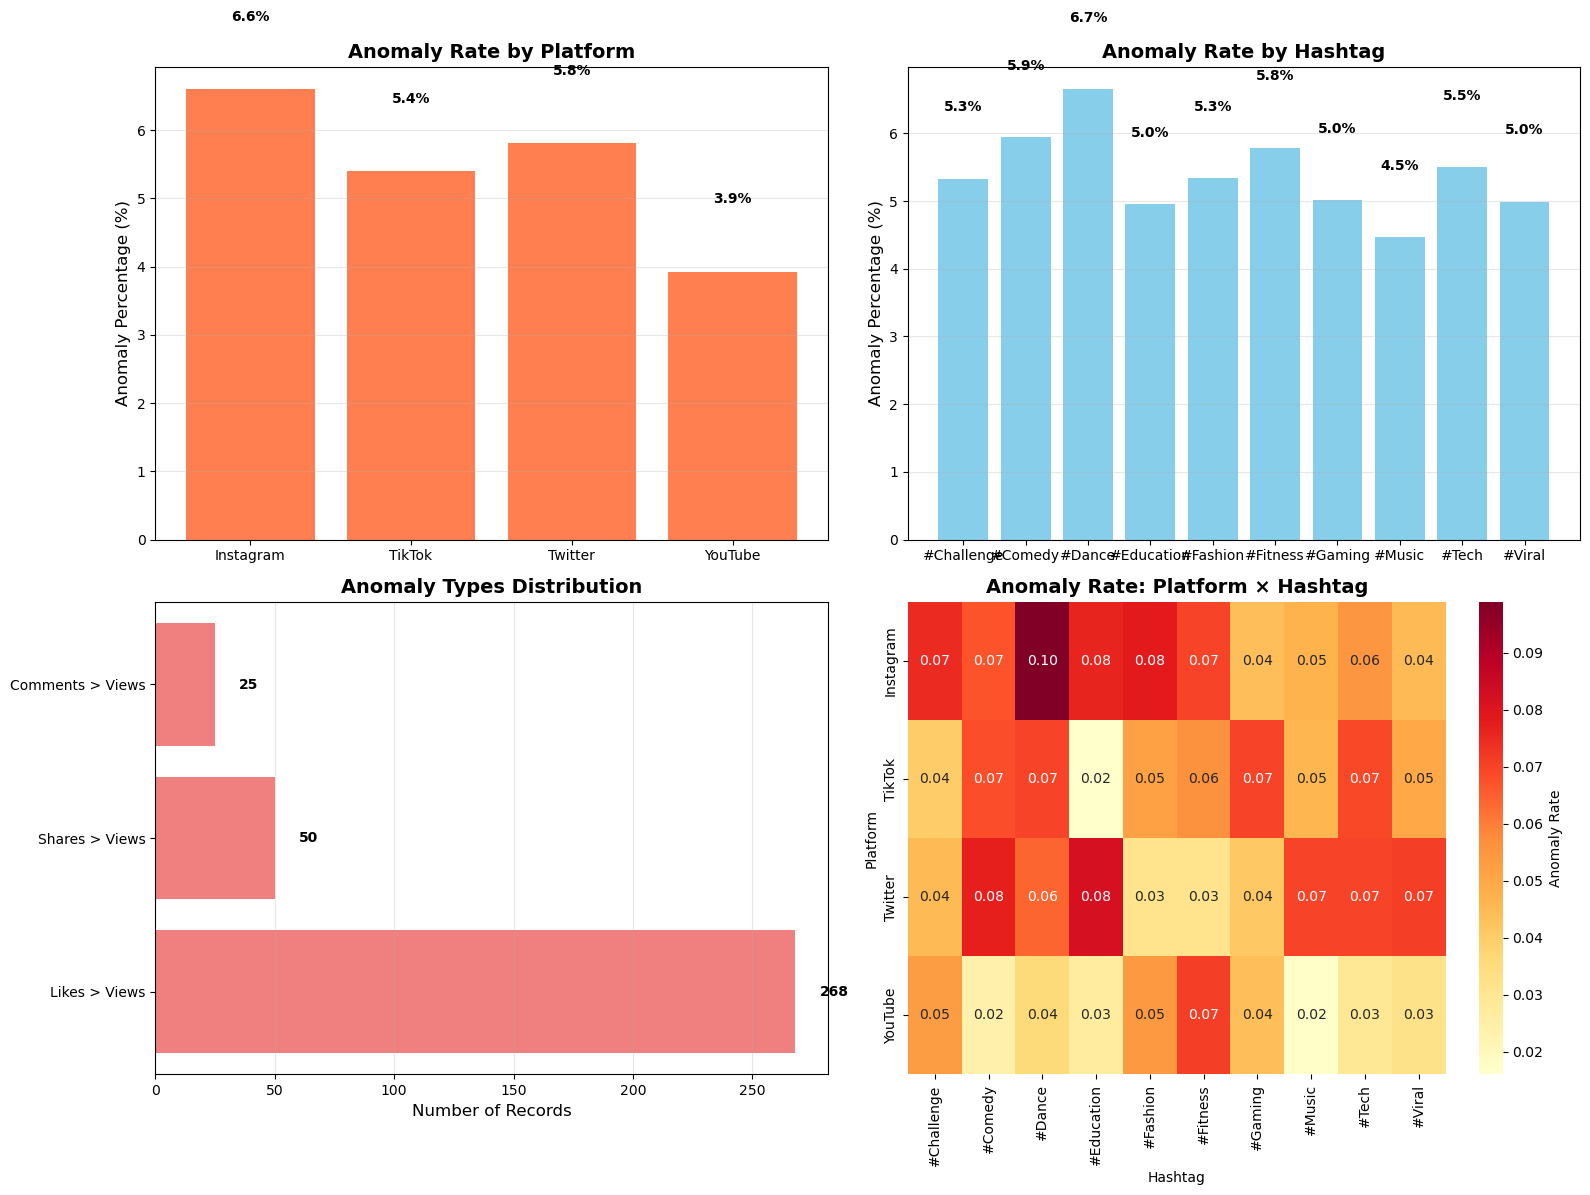


✅ Anomaly analysis visualization saved!


In [110]:
# ========================================
# STEP 4: ANOMALY PATTERN ANALYSIS (EDA)
# ========================================

print("\n" + "="*60)
print("STEP 4: Anomaly Pattern Analysis")
print("="*60)

# Platform analysis
print("\n📊 Anomalies by Platform:")
platform_anomaly = df_raw.groupby('Platform').agg({
    'likes_anomaly': 'sum',
    'shares_anomaly': 'sum',
    'comments_anomaly': 'sum',
    'any_anomaly': ['sum', 'mean']
}).round(3)
print(platform_anomaly)

# Hashtag analysis
print("\n📊 Anomalies by Hashtag:")
hashtag_anomaly = df_raw.groupby('Hashtag').agg({
    'likes_anomaly': 'sum',
    'shares_anomaly': 'sum',
    'comments_anomaly': 'sum',
    'any_anomaly': ['sum', 'mean']
}).round(3)
print(hashtag_anomaly)

# Region analysis
print("\n📊 Anomalies by Region:")
region_anomaly = df_raw.groupby('Region').agg({
    'any_anomaly': ['sum', 'mean']
}).round(3)
print(region_anomaly)

# Cross-analysis: Platform + Hashtag
print("\n📊 Anomalies by Platform × Hashtag:")
cross_analysis = pd.crosstab(
    df_raw['Platform'], 
    df_raw['Hashtag'], 
    values=df_raw['any_anomaly'], 
    aggfunc='mean'
).round(3)
print(cross_analysis)

# ========================================
# STEP 5: VISUALIZATION OF ANOMALY PATTERNS
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Anomalies by Platform
platform_counts = df_raw.groupby('Platform')['any_anomaly'].agg(['sum', 'count'])
platform_counts['percentage'] = (platform_counts['sum'] / platform_counts['count'] * 100)
axes[0, 0].bar(platform_counts.index, platform_counts['percentage'], color='coral')
axes[0, 0].set_ylabel('Anomaly Percentage (%)', fontsize=12)
axes[0, 0].set_title('Anomaly Rate by Platform', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(platform_counts['percentage']):
    axes[0, 0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Plot 2: Anomalies by Hashtag
hashtag_counts = df_raw.groupby('Hashtag')['any_anomaly'].agg(['sum', 'count'])
hashtag_counts['percentage'] = (hashtag_counts['sum'] / hashtag_counts['count'] * 100)
axes[0, 1].bar(hashtag_counts.index, hashtag_counts['percentage'], color='skyblue')
axes[0, 1].set_ylabel('Anomaly Percentage (%)', fontsize=12)
axes[0, 1].set_title('Anomaly Rate by Hashtag', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(hashtag_counts['percentage']):
    axes[0, 1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Plot 3: Anomaly type distribution
anomaly_types = pd.DataFrame({
    'Type': ['Likes > Views', 'Shares > Views', 'Comments > Views'],
    'Count': [df_raw['likes_anomaly'].sum(), df_raw['shares_anomaly'].sum(), df_raw['comments_anomaly'].sum()]
})
axes[1, 0].barh(anomaly_types['Type'], anomaly_types['Count'], color='lightcoral')
axes[1, 0].set_xlabel('Number of Records', fontsize=12)
axes[1, 0].set_title('Anomaly Types Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(anomaly_types['Count']):
    axes[1, 0].text(v + 10, i, str(v), va='center', fontweight='bold')

# Plot 4: Heatmap of Platform × Hashtag anomalies
sns.heatmap(cross_analysis, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Anomaly Rate'})
axes[1, 1].set_title('Anomaly Rate: Platform × Hashtag', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'anomaly_pattern_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Anomaly analysis visualization saved!")

## Split Train/Test 

In [ ]:
# TODO : Refer project brief and claude and make functions 


NOMINAL_COLS = ['Platform', 'Hashtag', 'Region', 'Content_Type']
ORDINAL_COLS = ['Engagement_Level']
ORDINAL_CATEGORIES = [['High', 'Medium', 'Low']]
NUMERIC_COLS = ['Views', 'Likes', 'Shares', 'Comments',
                'share_rate', 'comment_rate', 'likes_per_share',
                'likes_per_comment', 'comment_to_like_ratio',
                'share_to_like_ratio', 'virality_score',
                'engagement_density', 'total_interactions', 'anomaly_count']
ANOMALY_COLS = ['likes_anomaly', 'shares_anomaly', 'comments_anomaly', 'any_anomaly']

feature_cols = NOMINAL_COLS + ORDINAL_COLS +  NUMERIC_COLS
targets = NUMERIC_COLS 
target_cal = ORDINAL_COLS + ANOMALY_COLS

X = df_raw[feature_cols].copy()
y_reg = df_raw[targets].copy()
y_cal = df_raw[target_cal].copy()

X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

y_train_cal = y_cal.loc[y_train_reg.index]
y_test_cal = y_cal.loc[y_test_reg.index]

print(f"✅ Step 2 complete:")
print(f"   TRAIN: {len(X_train):,} samples")
print(f"   TEST:  {len(X_test):,} samples")
print(f"\n⚠️ NO FITTING HAS OCCURRED YET - ALL STATISTICS WILL USE TRAIN ONLY")

print(X_train)
print(X_test)





KeyError: "['Engagement_Rate'] not in index"

## Handle Outliers

In [ ]:
train_outliers_total_reg = 0
test_outliers_total_reg = 0



for col in y_train_reg.columns:
    # Calculate bounds using training data only
    lower, upper = calculate_iqr_bounds(y_train_reg[col], IQR_MULTIPLIER)
    print(f"\n📊 {col}")
    print(f"IQR bounds (TRAIN): {lower:.2f} to {upper:.2f}")

    # Count outliers in train set
    train_outliers = ((y_train_reg[col] < lower) | (y_train_reg[col] > upper)).sum()
    train_outliers_total_reg += train_outliers

    # Count outliers in test set using same bounds
    test_outliers = ((y_test_reg[col] < lower) | (y_test_reg[col] > upper)).sum()
    test_outliers_total_reg += test_outliers

    print(f"Outliers detected in TRAIN={train_outliers:,}, TEST={test_outliers:,}")

print("\n✅ TOTAL OUTLIERS:")
print(f"TRAIN TOTAL = {train_outliers_total_reg:,}")
print(f"TEST TOTAL  = {test_outliers_total_reg:,}")

if train_outliers_total_reg == 0 and test_outliers_total_reg == 0:
    print("No outliers detected in any target variable. Skipping outlier removal.")

else:

    # Create combined masks
    mask_train_all = pd.Series(True, index=y_train_reg.index)
    mask_test_all = pd.Series(True, index=y_test_reg.index)

    # Remove Outliers
    for col in y_train_reg.columns:
        lower, upper = calculate_iqr_bounds(y_train_reg[col], IQR_MULTIPLIER)

        # if there are outliers present initialize the row to False
        mask_train_all &= (y_train_reg[col] >= lower) & (y_train_reg[col] <= upper)
        mask_test_all &= (y_test_reg[col] >= lower) & (y_test_reg[col] <= upper)

        # Apply masks (remove rows that are outliers in ANY target)
        X_train= X_train[mask_train_all]
        y_train_reg = y_train_reg[mask_train_all]

        X_test = X_test[mask_test_all]
        y_test_reg = y_test_reg[mask_test_all]

        print(f"✅ Outlier removal complete.")
        print(f"Remaining samples — TRAIN: {len(X_train)}, TEST: {len(X_test)}")

# 
X_train
# test_outliers = ((y_test < price_lower) | (y_test > price_upper)).sum()
# print(f"Outliers detected: TRAIN={train_outliers:,}, TEST={test_outliers:,}")


📊 Views
IQR bounds (TRAIN): -2619189.00 to 7552085.00
Outliers detected in TRAIN=0, TEST=0

📊 Likes
IQR bounds (TRAIN): -245510.25 to 746031.75
Outliers detected in TRAIN=0, TEST=0

📊 Shares
IQR bounds (TRAIN): -50809.25 to 151706.75
Outliers detected in TRAIN=0, TEST=0

📊 Comments
IQR bounds (TRAIN): -24044.50 to 73531.50
Outliers detected in TRAIN=0, TEST=0

📊 Engagement_Rate
IQR bounds (TRAIN): -20.60 to 54.93
Outliers detected in TRAIN=476, TEST=132

✅ TOTAL OUTLIERS:
TRAIN TOTAL = 476
TEST TOTAL  = 132
✅ Outlier removal complete.
Remaining samples — TRAIN: 4000, TEST: 1000
✅ Outlier removal complete.
Remaining samples — TRAIN: 4000, TEST: 1000
✅ Outlier removal complete.
Remaining samples — TRAIN: 4000, TEST: 1000
✅ Outlier removal complete.
Remaining samples — TRAIN: 4000, TEST: 1000
✅ Outlier removal complete.
Remaining samples — TRAIN: 3524, TEST: 868


,Platform,Hashtag,Region,Content_Type,Engagement_Level,Views,Likes,Shares,Comments,Engagement_Rate
4676,TikTok,#Comedy,Australia,Shorts,Low,2366043,87673,4121,25516,4.958067
3671,YouTube,#Education,Japan,Post,Low,725454,149682,27039,47514,30.909610
2968,Twitter,#Dance,Germany,Tweet,Low,2628041,30963,1657,17698,1.914658
4793,Instagram,#Tech,Brazil,Video,Low,1986024,232499,19425,23352,13.860658
4368,YouTube,#Challenge,Japan,Shorts,Low,903431,290789,94929,34805,46.547329
...,...,...,...,...,...,...,...,...,...,...
3444,YouTube,#Viral,Brazil,Tweet,Low,2933029,398166,7891,14705,14.345647
4426,YouTube,#Viral,Germany,Reel,Low,4983897,256077,71883,39186,7.366645
466,Twitter,#Fitness,Australia,Tweet,Low,3684089,213042,71881,21008,8.304115
3092,TikTok,#Tech,Australia,Post,Low,921025,77092,85563,8320,18.563557


## Scale and Encode

In [ ]:
preprocessor = build_preprocessor(NOMINAL_COLS, ORDINAL_COLS, ORDINAL_CATEGORIES, NUMERIC_COLS)

print("Fitting preprocessor on TRAIN...")
preprocessor.fit(X_train)


X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


print(f"\n✅ Steps 6 & 7 complete:")
print(f"   TRAIN shape: {X_train_transformed.shape}")
print(f"   TEST shape:  {X_test_transformed.shape}")

feature_names = extract_feature_names(preprocessor)
print(f"   Features: {len(feature_names)}")


# Save
joblib.dump(preprocessor, ARTIFACTS_DIR / 'preprocessor.joblib')
with open(ARTIFACTS_DIR / 'feature_names.json', 'w') as f:
    json.dump(feature_names, f, indent=2)

# Encode classification targets using Pandas categorical accessor

y_train_cat = y_train_cal['Engagement_Level'].astype('category')
y_train_cat = y_train_cat.cat.reorder_categories(['Low', 'Medium', 'High'], ordered=True)

y_test_cat = y_test_cal['Engagement_Level'].astype('category')
y_test_cat = y_test_cat.cat.reorder_categories(['Low', 'Medium', 'High'], ordered=True)

X_test_transformed

print(f"\n✅ Preprocessor saved")

Fitting preprocessor on TRAIN...

✅ Steps 6 & 7 complete:
   TRAIN shape: (3524, 34)
   TEST shape:  (868, 34)
   Features: 34

✅ Preprocessor saved


## Save artifacts

In [ ]:
# Save regression arrays
np.savez_compressed(ARTIFACTS_DIR / 'X_train_reg.npz', data=X_train_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'X_test_reg.npz', data=X_test_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'y_train_reg.npz', data=y_train_reg.values)
np.savez_compressed(ARTIFACTS_DIR / 'y_test_reg.npz', data=y_test_reg.values)

# Save classification arrays
np.savez_compressed(ARTIFACTS_DIR / 'X_train_cls.npz', data=X_train_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'X_test_cls.npz', data=X_test_transformed)
np.savez_compressed(ARTIFACTS_DIR / 'y_train_cls.npz', data=y_train_cat.cat.codes.values)
np.savez_compressed(ARTIFACTS_DIR / 'y_test_cls.npz', data=y_test_cat.cat.codes.values)

print("✅ All artifacts saved:")
print(f"   - Preprocessor & feature names")
print(f"   - Regression arrays (TRAIN/TEST)")
print(f"   - Classification arrays (TRAIN/TEST)")


✅ All artifacts saved:
   - Preprocessor & feature names
   - Regression arrays (TRAIN/TEST)
   - Classification arrays (TRAIN/TEST)
